# Assignment 3

In [1]:
import gzip
import json
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

import torch
from torch import tensor
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import torch.nn.functional as F

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with gzip.open('xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

conn=np.load('xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

congestion_data = np.load('xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape = [instances.shape[0],])


def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst


for k in range(instances.shape[0]):
    #print(k)
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
        
instances['routing_demand'] = demand

In [3]:
instances.head()

,name,id,xloc,yloc,cell,orient,routing_demand
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0


In [4]:
# Data Preprocessing
data = Data(
    X = tensor(instances.drop(columns=['id', 'name', 'routing_demand']).values).float(),
    y = tensor(demand).float(),
    edge_index = torch.tensor([A.tocoo().row, A.tocoo().col])
)
data

/var/folders/rg/mvn599q51g5_76hcm5b9cjgw0000gn/T/ipykernel_20109/4092076974.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/torch/csrc/utils/tensor_new.cpp:248.)
  edge_index = torch.tensor([A.tocoo().row, A.tocoo().col])


Data(edge_index=[2, 141472], y=[3952], X=[3952, 4])

## 1.a

In [5]:
# Split data into training and testing sets
seed = 19
torch.manual_seed(seed)
split = RandomNodeSplit(num_splits=1, num_val=0.0, num_test=0.3)
split_data = split(data)
split_data.train_mask.shape

X_train, y_train = data.X[split_data.train_mask], data.y[split_data.train_mask]
train_indices = torch.argwhere(split_data.train_mask)
edge_index_train_mask = torch.isin(data.edge_index.t(), train_indices).sum(dim=1) == 2
edge_index_train = data.edge_index.t()[edge_index_train_mask].t()
train_instances = instances[split_data.train_mask.numpy()].reset_index(drop=True)
edge_index_train = edge_index_train.apply_(lambda x: train_instances[train_instances.id==x].index.values[0])

X_test, y_test = data.X[split_data.test_mask], data.y[split_data.test_mask]
test_indices = torch.argwhere(split_data.test_mask)
edge_index_test_mask = torch.isin(data.edge_index.t(), test_indices).sum(dim=1) == 2
edge_index_test = data.edge_index.t()[edge_index_test_mask].t()
test_instances = instances[split_data.test_mask.numpy()].reset_index(drop=True)
edge_index_test = edge_index_test.apply_(lambda x: test_instances[test_instances.id==x].index.values[0])

train_data = Data(X=X_train, y=y_train, edge_index=edge_index_train)
test_data = Data(X=X_test, y=y_test, edge_index=edge_index_test)

/Users/twshen/anaconda3/lib/python3.11/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_index', 'X'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [6]:
# Network Architecture
class GCN(nn.Module):
    def __init__(self, input_size, hidden_channels, hidden_layers):
        super(GCN, self).__init__()
        self.input_size = input_size
        self.hidden_channels = hidden_channels
        self.hidden_layers = hidden_layers
        
        self.layers = nn.ModuleList()
        self.layers.append(GCNConv(self.input_size, self.hidden_channels))
        for _ in range(self.hidden_layers):
            self.layers.append(GCNConv(self.hidden_channels, self.hidden_channels))
        self.layers.append(nn.Linear(self.hidden_channels, 1))
    
    def forward(self, data):
        x, edge_index = data.X, data.edge_index
        
        for i, layer in enumerate(self.layers):
            if i <= self.hidden_layers:
                x = layer(x, edge_index)
                x = F.relu(x)
            else:
                x = layer(x)
        return x

In [7]:
# Train
def train(mdl, epochs=5000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(mdl.parameters(), lr=0.002, weight_decay=5e-6)
    
    train_losses = np.array([])
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        output = mdl(train_data)
        
        loss = criterion(output, train_data.y)
        train_losses = np.append(train_losses, loss.detach().numpy())
        loss.backward()
        optimizer.step()
        
        #if epoch % 500 == 0:
            #print(f'Epoch {epoch} Loss: {loss}')
    return loss

In [8]:
# Train 1-5 hidden layer GCNs
input_size = 4
hidden_channels = 48
criterion = nn.MSELoss()

test_losses = np.array([])

for i in range(1,6):
    print(f'Training model with {i} layer(s)')
    
    mdl = GCN(input_size=input_size, hidden_channels=hidden_channels, hidden_layers=i)
    mdl.train()
    train(mdl)
    mdl.eval()
    with torch.no_grad():
        test_loss = criterion(mdl(test_data), test_data.y)
        print(f'{i}-layer Testing Loss: {test_loss}')
        test_losses = np.append(test_losses, test_loss.detach().numpy())

Training model with 1 layer(s)


  0%|                                                  | 0/5000 [00:00<?, ?it/s]/Users/twshen/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2766])) that is different to the input size (torch.Size([2766, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████| 5000/5000 [01:43<00:00, 48.38it/s]
/Users/twshen/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1186])) that is different to the input size (torch.Size([1186, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1-layer Testing Loss: 210.19895935058594
Training model with 2 layer(s)


100%|███████████████████████████████████████| 5000/5000 [02:21<00:00, 35.33it/s]


2-layer Testing Loss: 132.0433807373047
Training model with 3 layer(s)


100%|███████████████████████████████████████| 5000/5000 [02:59<00:00, 27.93it/s]


3-layer Testing Loss: 1070.0345458984375
Training model with 4 layer(s)


100%|███████████████████████████████████████| 5000/5000 [03:39<00:00, 22.76it/s]


4-layer Testing Loss: 365.4933776855469
Training model with 5 layer(s)


100%|███████████████████████████████████████| 5000/5000 [04:19<00:00, 19.30it/s]

5-layer Testing Loss: 15532.548828125


<Axes: >

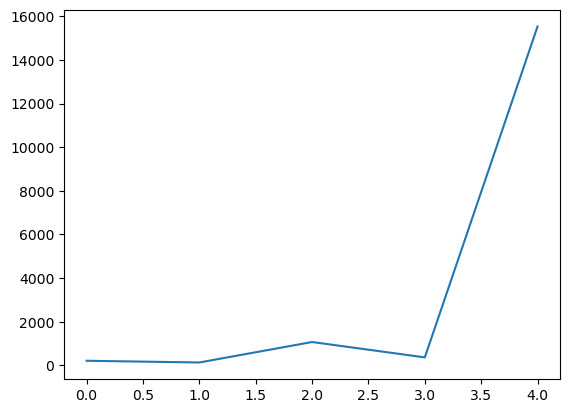

In [9]:
sns.lineplot(x=range(len(test_losses)), y=test_losses)

## 1.b

In [12]:
class GAT(nn.Module):
    def __init__(self, input_size, hidden_channels, hidden_layers):
        super(GAT, self).__init__()
        self.input_size = input_size
        self.hidden_channels = hidden_channels
        self.hidden_layers = hidden_layers
        
        self.layers = nn.ModuleList()
        self.layers.append(GATConv(input_size, hidden_channels))
        for _ in range(self.hidden_layers):
            self.layers.append(GATConv(hidden_channels, hidden_channels))
        self.layers.append(nn.Linear(self.hidden_channels, 1))
    
    def forward(self, data):
        x, edge_index = data.X, data.edge_index
        
        for i, layer in enumerate(self.layers):
            if i <= self.hidden_layers:
                x = layer(x, edge_index)
                x = F.relu(x)
            else:
                x = layer(x)
        return x

In [13]:
input_size = 4
hidden_channels = 48
criterion = nn.MSELoss()

test_losses = np.array([])

for i in range(1,6):
    print(f'Training model with {i} layer(s)')
    
    mdl = GAT(input_size=input_size, hidden_channels=hidden_channels, hidden_layers=i)
    mdl.train()
    train(mdl)
    mdl.eval()
    with torch.no_grad():
        test_loss = criterion(mdl(test_data), test_data.y)
        print(f'{i}-layer Testing Loss: {test_loss}')
        test_losses = np.append(test_losses, test_loss.detach().numpy())

Training model with 1 layer(s)


  0%|                                                  | 0/5000 [00:00<?, ?it/s]/Users/twshen/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2766])) that is different to the input size (torch.Size([2766, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████| 5000/5000 [03:13<00:00, 25.86it/s]
/Users/twshen/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1186])) that is different to the input size (torch.Size([1186, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1-layer Testing Loss: 201.61083984375
Training model with 2 layer(s)


100%|███████████████████████████████████████| 5000/5000 [04:41<00:00, 17.79it/s]


2-layer Testing Loss: 224.01876831054688
Training model with 3 layer(s)


100%|███████████████████████████████████████| 5000/5000 [26:23<00:00,  3.16it/s]


3-layer Testing Loss: 340.8153076171875
Training model with 4 layer(s)


100%|███████████████████████████████████████| 5000/5000 [22:49<00:00,  3.65it/s]


4-layer Testing Loss: 568.5868530273438
Training model with 5 layer(s)


100%|███████████████████████████████████████| 5000/5000 [26:14<00:00,  3.18it/s]

5-layer Testing Loss: 84.68852996826172


<Axes: >

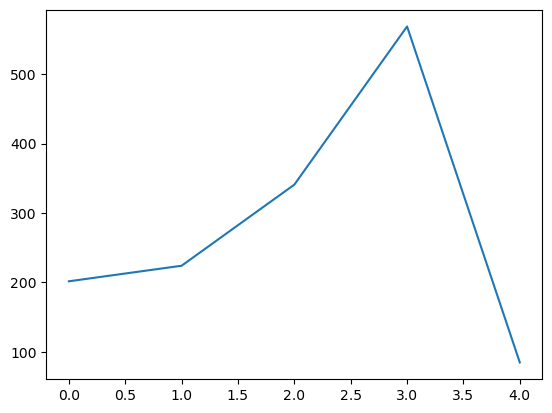

In [14]:
sns.lineplot(x=range(len(test_losses)), y=test_losses)

## 2.a

In [16]:
seed = 19

def load_xbar(i):
    with gzip.open(f'xbar/{i}/xbar.json.gz','rb') as f:
        design = json.loads(f.read().decode('utf-8'))

    instances = pd.DataFrame(design['instances'])
    nets = pd.DataFrame(design['nets'])

    conn=np.load(f'xbar/{i}/xbar_connectivity.npz')
    A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
    A = A.__mul__(A.T)

    def buildBST(array,start=0,finish=-1):
        if finish<0:
            finish = len(array)
        mid = (start + finish) // 2
        if mid-start==1:
            ltl=start
        else:
            ltl=buildBST(array,start,mid)

        if finish-mid==1:
            gtl=mid
        else:
            gtl=buildBST(array,mid,finish)

        return((array[mid],ltl,gtl))

    congestion_data = np.load(f'xbar/{i}/xbar_congestion.npz')
    xbst=buildBST(congestion_data['xBoundaryList'])
    ybst=buildBST(congestion_data['yBoundaryList'])
    demand = np.zeros(shape = [instances.shape[0],])


    def getGRCIndex(x,y,xbst,ybst):
        while (type(xbst)==tuple):
            if x < xbst[0]:
                xbst=xbst[1]
            else:
                xbst=xbst[2]

        while (type(ybst)==tuple):
            if y < ybst[0]:
                ybst=ybst[1]
            else:
                ybst=ybst[2]

        return ybst, xbst


    for k in range(instances.shape[0]):
        #print(k)
        xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
        i,j=getGRCIndex(xloc,yloc,xbst,ybst)
        d = 0 
        for l in list(congestion_data['layerList']): 
            lyr=list(congestion_data['layerList']).index(l)
            d += congestion_data['demand'][lyr][i][j]
        demand[k] = d

    instances['routing_demand'] = demand
    
    data = Data(
        X = tensor(instances.drop(columns=['id', 'name', 'routing_demand']).values).float(),
        y = tensor(demand).float(),
        edge_index = torch.tensor([A.tocoo().row, A.tocoo().col])
    )
    
    return data

In [24]:
training_losses = np.array([])
testing_losses = np.array([])

input_size=4
hidden_channels=8
hidden_layers=2
criterion = nn.MSELoss()

for i in range(1,5):
    mdl = GCN(input_size, hidden_channels, hidden_layers)
    training_loss_it = np.array([])
    mdl.train()
    for j in range(1,5):
        if i==j:
            pass
        train_data = load_xbar(j)
        train_loss = train(mdl, 500)
        training_loss_it = np.append(training_loss_it, train_loss.detach().numpy())
    test_data = load_xbar(i)
    mdl.eval()
    with torch.no_grad():
        test_loss = criterion(mdl(test_data), test_data.y)
        testing_losses = np.append(testing_losses, test_loss.detach().numpy())
        training_losses = np.append(training_losses, training_loss_it.mean())

  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/twshen/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3952])) that is different to the input size (torch.Size([3952, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/twshen/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6872])) that is different to the input size (torch.Size([6872, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/twshen/anaconda3/lib/python3.

100%|█████████████████████████████████████████| 500/500 [00:31<00:00, 15.72it/s]
/Users/twshen/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6913])) that is different to the input size (torch.Size([6913, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/twshen/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3952])) that is different to the input size (torch.Size([3952, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/twshen/anaconda3/lib/python3

In [25]:
training_losses

array([162.35744019, 123.80272827, 101.94646683,  62.10348701,
        55.33110924])

In [26]:
testing_losses

array([ 93.37306976, 270.30410767,  93.46062469,  57.09708786,
        53.86576462])